In [1]:
%load_ext tensorboard

In [8]:
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankcle boot'
]

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
print("Image shape:", train_images[0].shape)
print("Label", train_labels[0], "->", class_names[train_labels[0]])

Image shape: (28, 28)
Label 9 -> Ankcle boot


In [67]:
# Visualize a single image in TensorBoard
img = train_images[0].reshape(-1, 28, 28, 1)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('logs', 'train_data', current_time)
file_writer = tf.summary.create_file_writer(logdir)

with file_writer.as_default():
    tf.summary.image("Training data", img, step=0)

In [15]:
# Visualize multiple images
with file_writer.as_default():
    images = train_images[:10].reshape(-1, 28, 28, 1)
    tf.summary.image("10 training data examples", images, max_outputs=10, step=0)

### Show figure created by Maplotlib in TensorBoard
---

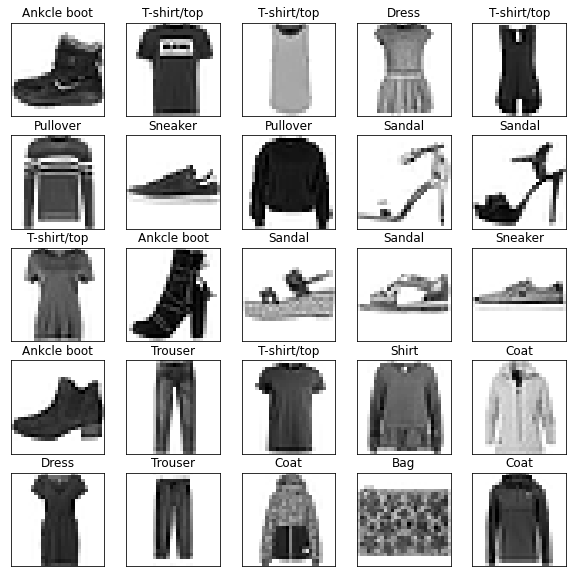

In [36]:
# A grid of images made by matplotlib

figure = plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1, title=class_names[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    

In [68]:
def plot_to_image(figure):
    """figure (PNG) -> TF image"""
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image


figure = plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1, title=class_names[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)

with file_writer.as_default():
    image = plot_to_image(figure)
    tf.summary.image("Train data (grid)", image, step=0)

### Train classifier and show confusion matrics
---

In [92]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankcle boot'
]


train_images = train_images.astype('float32') / 255
train_images = train_images[..., None]

test_images = test_images.astype('float32') / 255
test_images = test_images[..., None]

In [135]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10),
])

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

In [141]:
!rm -rf logs/image

logdir = os.path.join("logs", "image", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

file_writer_cm = tf.summary.create_file_writer(os.path.join(logdir, 'confusion_matrix'))

In [133]:
def plot_confusion_matrix(confusion_matrix, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # normalize
    confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
    
    threshold = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        color = "white" if confusion_matrix[i, j] > threshold else "black"
        plt.text(j, i, confusion_matrix[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure
    

def plot_to_image(figure):
    """figure (PNG) -> TF image"""
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image


def log_confusion_matrix(epoch, logs):
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    figure = plot_confusion_matrix(confusion_matrix, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)
        
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [143]:
model.fit(
    train_images, train_labels,
    epochs=5,
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels),
)

Epoch 1/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6640 - accuracy: 0.7824 - val_loss: 0.4262 - val_accuracy: 0.8779
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6541 - accuracy: 0.7864 - val_loss: 0.4264 - val_accuracy: 0.8807
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.6406 - accuracy: 0.7921 - val_loss: 0.4270 - val_accuracy: 0.8774
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6370 - accuracy: 0.7913 - val_loss: 0.4235 - val_accuracy: 0.8797
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6309 - accuracy: 0.7951 - val_loss: 0.4213 - val_accuracy: 0.8819


In [144]:
%tensorboard --logdir logs/image

Reusing TensorBoard on port 6006 (pid 16258), started 0:07:44 ago. (Use '!kill 16258' to kill it.)